In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, AdaBoostClassifier
from scipy.stats import mode
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pickle

Load the dataset

In [2]:
# Load the data into a Pandas DataFrame
df = pd.read_csv("datasetWithNonAccidents.csv")
df.head()

,Lat,Long,Day,Time,Weather,Light,Severity,Sex,Age,Vehicle_type,Vehicle_age
0,6.871939,79.901487,1.0,19.00,1.0,2.0,3.0,1.0,26.0,5.0,2.0
1,6.871939,79.901487,1.0,19.00,1.0,2.0,3.0,NaN,NaN,1.0,2.0
2,6.884665,79.907132,7.0,8.50,1.0,1.0,4.0,1.0,26.0,1.0,6.0
3,6.884665,79.907132,7.0,8.50,1.0,1.0,4.0,1.0,42.0,1.0,2.0
4,6.877136,79.892977,5.0,12.55,1.0,1.0,4.0,1.0,39.0,2.0,13.0


Data exploration and preprocessing

In [3]:
#Check for missing values
print(df.isnull().sum())

Lat             30
Long            30
Day              5
Time             8
Weather          2
Light            2
Severity         7
Sex             43
Age             57
Vehicle_type    11
Vehicle_age     19
dtype: int64


In [4]:
#Drop any records that contain missing values on Lat, Long columns
df = df.dropna(subset=['Lat', 'Long'])

In [5]:
# Outlier detection using Interquartile range (IQR)
def detect_outliers(df, var):
    Q1 = df[var].quantile(0.25)
    Q3 = df[var].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[var] < lower_bound) | (df[var] > upper_bound)]
    return outliers

outliers_lat = detect_outliers(df, 'Lat')
outliers_lon = detect_outliers(df, 'Long')
outliers_time = detect_outliers(df, 'Time')
outliers_age = detect_outliers(df, 'Age')
outliers_vehicle_age = detect_outliers(df, 'Vehicle_age')

In [6]:
# Replace missing values with mode of the column
df.fillna(df.mode().iloc[0], inplace=True)

In [7]:
df.shape

(944, 11)

Feature Engineering

In [8]:
#Scaling
scaler = StandardScaler()

# def normalize(features):
#   scaled_data = preprocessing.normalize(features, axis=0)
#   print(scaled_data)
#   return scaled_data

def standardization(features):
  # scaler = StandardScaler()
  scaled_data = scaler.fit_transform(features);
  print(scaled_data)
  return scaled_data

# def minMaxScaler(features): 
#   scaler = MinMaxScaler()
#   scaled_data = scaler.fit_transform(features);
#   print(scaled_data)
#   return scaled_data


Feature selection

                   Lat      Long       Day      Time   Weather     Light  \
Lat           1.000000 -0.080745  0.032522 -0.017865 -0.117386 -0.042416   
Long         -0.080745  1.000000  0.122725  0.033529  0.108849  0.075577   
Day           0.032522  0.122725  1.000000  0.003181  0.006047  0.008552   
Time         -0.017865  0.033529  0.003181  1.000000 -0.027238  0.239278   
Weather      -0.117386  0.108849  0.006047 -0.027238  1.000000  0.157372   
Light        -0.042416  0.075577  0.008552  0.239278  0.157372  1.000000   
Severity      0.247504 -0.154570 -0.112315  0.020955 -0.560406 -0.239921   
Sex          -0.125424  0.064199  0.047005  0.042370  0.330607  0.146648   
Age          -0.053904  0.081695  0.033445 -0.083718  0.159432 -0.060751   
Vehicle_type -0.107785  0.081910  0.087140 -0.000127  0.198116  0.100597   
Vehicle_age   0.012161  0.062457 -0.057282 -0.052257  0.158706  0.034315   

              Severity       Sex       Age  Vehicle_type  Vehicle_age  
Lat           0

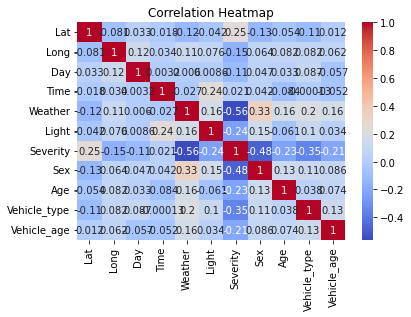

In [9]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Display the correlation matrix
print(corr_matrix)

# Visualize the correlation matrix using a heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

Split the dataset

In [10]:
# Split the data into training and test sets
features = df.drop('Severity', axis=1)
y = df['Severity']
X = standardization(features) #scaled data

[[ 0.13548839  0.09655701 -1.55300577 ... -1.14828804  0.81212946
  -0.96115045]
 [ 0.13548839  0.09655701 -1.55300577 ... -0.67631644 -1.10569471
  -0.96115045]
 [ 1.72219772  0.67135305  1.6122424  ... -1.14828804 -1.10569471
  -0.36176084]
 ...
 [-0.09866532 -1.29944894 -1.0254644  ... -0.0020713   1.2915855
   0.08778137]
 [ 1.54913843  1.05023985 -0.49792304 ...  0.94187189 -1.10569471
  -0.36176084]
 [ 1.05365023  0.46475231  1.08470104 ... -1.14828804  0.81212946
   0.98686579]]


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [12]:
X

array([[ 0.13548839,  0.09655701, -1.55300577, ..., -1.14828804,
         0.81212946, -0.96115045],
       [ 0.13548839,  0.09655701, -1.55300577, ..., -0.67631644,
        -1.10569471, -0.96115045],
       [ 1.72219772,  0.67135305,  1.6122424 , ..., -1.14828804,
        -1.10569471, -0.36176084],
       ...,
       [-0.09866532, -1.29944894, -1.0254644 , ..., -0.0020713 ,
         1.2915855 ,  0.08778137],
       [ 1.54913843,  1.05023985, -0.49792304, ...,  0.94187189,
        -1.10569471, -0.36176084],
       [ 1.05365023,  0.46475231,  1.08470104, ..., -1.14828804,
         0.81212946,  0.98686579]])

In [13]:
y

0      3.0
1      3.0
2      4.0
3      4.0
4      4.0
      ... 
969    2.0
970    3.0
971    3.0
972    2.0
973    2.0
Name: Severity, Length: 944, dtype: float64

In [14]:
print(df.loc[y_test.index, ['Severity']])

# Get the Severity test data as a DataFrame
y_test_df = df.loc[y_test.index, ['Severity']]

# Save the DataFrame to a CSV file
y_test_df.to_csv('y_test.csv', index=False)

     Severity
668       0.0
575       0.0
718       0.0
14        4.0
275       3.0
..        ...
453       4.0
325       4.0
65        4.0
83        4.0
673       0.0

[189 rows x 1 columns]


In [15]:
# Get the column names from the original DataFrame
feature_cols = df.columns.drop('Severity')

# Convert X_test to a NumPy array
X_test_array = np.array(X_test)

# Create a new DataFrame with the NumPy array and column names
X_test_df = pd.DataFrame(X_test_array, columns=feature_cols)

# Print the DataFrame
print(X_test_df)

          Lat      Long       Day      Time   Weather     Light       Sex  \
0   -1.089642  0.378507 -1.553006 -0.436915 -0.525048 -0.758920 -0.613264   
1   -0.186442 -0.249033 -1.553006 -0.917805 -0.525048 -0.758920  1.630618   
2   -0.183075  0.754441  0.029618  1.081156  1.904587  1.317662 -0.613264   
3    1.324710 -1.027070 -0.497923 -0.405079 -0.525048 -0.758920 -0.613264   
4    1.670704  0.192475  0.029618 -0.911103 -0.525048 -0.758920 -0.613264   
..        ...       ...       ...       ...       ...       ...       ...   
184 -0.871198 -0.211257 -0.497923 -0.446969 -0.525048 -0.758920 -0.613264   
185  0.683094 -0.823015 -0.497923 -0.607824 -0.525048 -0.758920 -0.613264   
186  0.811766 -1.071567  0.557160 -0.262655 -0.525048 -0.758920 -0.613264   
187 -1.046502  1.283315  1.612242  0.089216 -0.525048 -0.758920 -0.613264   
188 -1.099492  0.435325  0.029618 -1.063580 -0.525048 -0.758920 -0.613264   

          Age  Vehicle_type  Vehicle_age  
0    1.953240      0.812129     

In [16]:
# Inverse transform the X_test data to get the original values
X_test_orig = scaler.inverse_transform(X_test)

# Print the X_test data with the column names
X_test_df = pd.DataFrame(X_test_orig, columns=features.columns)
print(X_test_df)

          Lat       Long  Day   Time  Weather  Light  Sex   Age  Vehicle_type  \
0    6.862113  79.904256  1.0  10.16      1.0    1.0  1.0  72.0           5.0   
1    6.869357  79.898093  1.0   7.29      1.0    1.0  2.0  51.0           6.0   
2    6.869384  79.907948  4.0  19.22      2.0    2.0  1.0  64.0           2.0   
3    6.881477  79.890452  3.0  10.35      1.0    1.0  1.0  33.0           1.0   
4    6.884252  79.902429  4.0   7.33      1.0    1.0  1.0  23.0           6.0   
..        ...        ...  ...    ...      ...    ...  ...   ...           ...   
184  6.863865  79.898464  3.0  10.10      1.0    1.0  1.0  31.0           2.0   
185  6.876331  79.892456  3.0   9.14      1.0    1.0  1.0  71.0           1.0   
186  6.877363  79.890015  5.0  11.20      1.0    1.0  1.0  37.0           6.0   
187  6.862459  79.913142  7.0  13.30      1.0    1.0  1.0  51.0           1.0   
188  6.862034  79.904814  4.0   6.42      1.0    1.0  1.0  25.0           6.0   

     Vehicle_age  
0       

In [17]:
X_test_df.to_csv('X_test.csv', index=False)

Modeling

In [18]:
ab=AdaBoostClassifier()
rf=RandomForestClassifier()


In [19]:
# Create an instance of the voting classifier
voting_clf = VotingClassifier(estimators=[('ab', ab), ('rf', rf)], voting='soft')


In [20]:
# Fit the voting classifier to the training data
voting_clf.fit(X_train, y_train)


VotingClassifier(estimators=[('ab', AdaBoostClassifier()),
                             ('rf', RandomForestClassifier())],
                 voting='soft')

In [21]:
# Make predictions using the voting classifier
y_pred = voting_clf.predict(X_test)

In [22]:
y_pred

array([0., 0., 0., 4., 3., 4., 2., 0., 0., 4., 4., 4., 1., 4., 4., 0., 4.,
       2., 0., 0., 0., 1., 4., 0., 2., 0., 4., 3., 0., 4., 4., 0., 0., 1.,
       4., 4., 4., 4., 0., 0., 0., 1., 0., 3., 4., 3., 4., 0., 4., 3., 0.,
       0., 0., 3., 4., 4., 4., 4., 4., 3., 0., 3., 4., 0., 0., 0., 0., 0.,
       0., 4., 4., 0., 3., 4., 4., 0., 0., 1., 4., 4., 0., 4., 0., 2., 0.,
       0., 4., 0., 4., 4., 3., 4., 0., 0., 0., 0., 2., 4., 0., 4., 0., 4.,
       4., 4., 0., 0., 0., 0., 4., 4., 0., 3., 1., 4., 0., 4., 0., 0., 4.,
       1., 0., 4., 0., 1., 4., 4., 0., 0., 4., 2., 0., 4., 0., 0., 4., 0.,
       4., 3., 3., 4., 4., 4., 1., 0., 0., 3., 2., 4., 0., 4., 4., 0., 0.,
       0., 0., 1., 4., 4., 1., 4., 4., 4., 4., 4., 3., 3., 0., 1., 0., 0.,
       4., 4., 4., 4., 0., 3., 4., 3., 0., 4., 4., 4., 0., 4., 4., 4., 4.,
       4., 0.])

Evaluation

In [23]:
# evaluate the performance
print("Accuracy: %0.4f" % accuracy_score(y_test, y_pred))
print("Precision: %0.4f" % precision_score(y_test, y_pred, average='weighted'))
print("Recall: %0.4f" % recall_score(y_test, y_pred, average='weighted'))
print("F1-score:  %0.4f" % f1_score(y_test, y_pred, average='weighted'))

Accuracy: 0.9206
Precision: 0.9247
Recall: 0.9206
F1-score:  0.9207


In [24]:
# Save the model as a pickle file
with open('votingModel.pkl', 'wb') as f:
    pickle.dump(voting_clf, f)

In [ ]:
# Create a pickle file for the scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)